# Identify zooplankton school from glider echosounder data with external location and environmental data incorporated

```{admonition} This notebook accompanies the following paper:
:class: tip
**Echopype: Interoperable and scalable echosounder data processing with Echopype**\
Authors: Wu-Jung Lee, Landung Setiawan, Caesar Tuguinay, Emilio Mayorga, and Valentina Staneva\
ICES Journal of Marine Science 2024: https://doi.org/10.1093/icesjms/fsae133
```

## Introduction

### Description

This notebook uses echosounder data from a glider to illustrate how Echopype can use external location (latitude and longitude) and environmental (temperature, salinity and pressure) data in the processing, if the data do not already exist in the echosounder raw files or if users would like to udpdate them. The data are provided by [Delphine Mossman](https://rucool.marine.rutgers.edu/people/delphine-mossman/) from the [Department of Marine and Coastal Sciences at Rutgers University](https://marine.rutgers.edu/). The data were a 15-min section of echosounder data collected by an [Acoustic Zooplankton and Fisher Profiler (AZFP)](https://aslenv.com/azfp.html) mounted on a Slocum glider deployed in the Southern Ocean off Antarctica (Ross Sea) in 2018.

In this notebook we attempt to correct for the glider orientation and identify zooplankton swarms in the echogram following steps detailed in the [2021 M.S. thesis from Ailey Sheehan](https://rucool.marine.rutgers.edu/wp-content/uploads/2022/06/Ailey_Thesis_FinalDraft.pdf), another member of the same Rutgers team. The computations are available in [the associated GitHub repository](https://github.com/a-sheehan/Echopype-Processing-Pipeline-for-AZFP-and-Glider-Data).

### Outline

1) [Open and convert raw AZFP data](###Open-and-convert-raw-AZFP-data)
2) [Update EchoData `Platform` group with glider data and metadata](###Update-EchoData-Platform-group-with-glider-data-and-metadata)
3) [Calibrate backscatter data with glider mean environmental data](###Calibrate-backscatter-data-with-glider-mean-environmental-data)
4) [Remove background noise](###Remove-Background-Noise)
5) [Align echosounder data according to depth](###Align-echosounder-data-according-to-depth)
6) [Compute and apply shoal mask on corrected Sv](###Compute-Shoal-Mask-and-Apply-on-Corrected-Sv)

### Running the notebook

This notebook can be run with a conda environment created using the [conda environment file](../conda/environment-ep-main.yml). It uses data files found in the `notebooks/example_data/glider_AZFP` directory in this repository.

### Note
We encourage importing Echopype as `ep` for consistency.

In [1]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import xarray as xr
from scipy.spatial.transform import Rotation as R
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import echopype as ep
import echopype.colormap

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

### Path setup

In [2]:
# Set path to example data
data_path = Path('./example_data/glider_AZFP')

## Data processing workflow

### Open and convert raw AZFP data

To open an AZFP data file (`*.01A` files), the accompanying `XML` metadata file must be provided.

In [3]:
# Open RAW
azfp_data_fpath = data_path / "18011107.01A"
ed = ep.open_raw(
    azfp_data_fpath, 
    xml_path=data_path / "18011107.XML", 
    sonar_model="AZFP"
)
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

AZFP raw data files doesn't contain latitude longitude data. Therefore, the `Platform` group should have NaNs for this location data:

In [4]:
# Print lat lon array data
print("Latitude Data:", ed["Platform"]["latitude"].data)
print("Longitude Data:", ed["Platform"]["longitude"].data)

Latitude Data: [nan]
Longitude Data: [nan]


### Update EchoData `Platform` group with glider data and metadata

Here we update the `EchoData` object with metadata entries for this deployment, and the GPS locations from the glider netCDF data.

#### Load external glider netCDF file

The glider data are available on [a Rutgers erddap server](http://slocum-data.marine.rutgers.edu/erddap/tabledap/ru32-20180109T0531-profile-sci-delayed.html). We have previously downloaded and subset that dataset to make it easier to use in this example.

In [5]:
# Open Glider Dataset
glider_nc_fpath = data_path / "ru32-20180109T0531-profile-sci-delayed-subset.nc"
ds_glider = xr.open_dataset(glider_nc_fpath)
ds_glider

<xarray.Dataset> Size: 454kB
Dimensions:                    (time: 915)
Coordinates:
  * time                       (time) datetime64[ns] 7kB 2018-01-11T07:26:20....
Data variables: (12/59)
    latitude                   (time) float64 7kB ...
    longitude                  (time) float64 7kB ...
    depth                      (time) float32 4kB ...
    trajectory                 (time) <U18 66kB ...
    source_file                (time) <U31 113kB ...
    beta_700nm                 (time) float32 4kB ...
    ...                         ...
    sci_water_pressure         (time) float32 4kB ...
    sound_speed                (time) float32 4kB ...
    temperature                (time) float32 4kB ...
    u                          (time) float32 4kB ...
    v                          (time) float32 4kB ...
    water_depth                (time) float32 4kB ...
Attributes: (12/72)
    cdm_data_type:                   Profile
    cdm_profile_variables:           profile_id
    comment:                         Glider was deployed/recovered from the R...
    contributor_name:                Grace Saba, Dave Aragon, Chip Haldeman, ...
    contributor_role:                Principal Investigator, Glider Pilot, Gl...
    Conventions:                     CF-1.6, COARDS, ACDD-1.3
    ...                              ...
    time_coverage_resolution:        PTS
    time_coverage_start:             2018-01-09T05:29:54Z
    title:                           ru32-20180109T0531 Delayed Science Profile
    uuid:                            82c40f91-87ab-40bb-a1ea-3f1c366a0378
    Westernmost_Easting:             164.36469500000004
    wmo_id:                          7801506

The external glider data time range encompasses that of the AZFP data. Let's compare the two time ranges:

In [6]:
# Show glider start and end time
print("Glider Start Time:", ds_glider.time.min().values)
print("Glider End Time:", ds_glider.time.max().values)

Glider Start Time: 2018-01-11T07:26:20.320559872
Glider End Time: 2018-01-11T08:00:28.788059904


In [7]:
# Show AZFP start and end time
print("AZFP Start Time", ed["Sonar/Beam_group1"]["ping_time"].min().values)
print("AZFP End Time", ed["Sonar/Beam_group1"]["ping_time"].max().values)

AZFP Start Time 2018-01-11T07:44:40.000000000
AZFP End Time 2018-01-11T07:59:59.000000000


#### Update EchoData `Top-level` and `Platform` group attributes

While not required for data processing, it's always a good idea to include as much metadata as possible. We'll take advantage of the metadata found in the glider netCDF file to populate some of these metadata.

In [8]:
# Manually populate additional metadata about the dataset and the platform
# -- SONAR-netCDF4 Top-level Group attributes
ed["Top-level"] = ed["Top-level"].assign_attrs(
    title="2018 Ross Sea Slocum glider AZFP echosounder data from Rutgers University",
    summary=ds_glider.attrs.get("summary", ""),
)

# -- SONAR-netCDF4 Platform Group attributes
ed["Platform"] = ed["Platform"].assign_attrs(
    platform_type=ds_glider.attrs.get("platform_type", ""),
    platform_name="Rutgers r32 Slocum Webb G2 glider",
    platform_code_ICES=ds_glider.attrs.get("wmo_id", ""),
)

Here are the updated attributes in the "Top-level" group:

In [9]:
# Show top level attributes
ed['Top-level'].attrs

{'conventions': 'CF-1.7, SONAR-netCDF4-1.0, ACDD-1.3',
 'keywords': 'AZFP',
 'sonar_convention_authority': 'ICES',
 'sonar_convention_name': 'SONAR-netCDF4',
 'sonar_convention_version': '1.0',
 'summary': 'This project integrated an Acoustic Zooplankton and Fish Profiler (AZFP) multi-frequency echo sounder into a Slocum Webb G2 glider. The AZFP is complemented with existing glider sensors including a CTD, a WET Labs BB2FL ECO puck configured for simultaneous chlorophyll fluorescence (phytoplankton biomass) and optical backscatter measurements, and an Aanderaa Optode for measuring dissolved oxygen. This glider deployment is located in the polynya of Terra Nova Bay (western Ross Sea, Antarctica), and is focused on investigating relationships between phytoplankton-zooplankton-fish distributions and the physical drivers of zooplankton and silverfish species and size distributions.',
 'title': '2018 Ross Sea Slocum glider AZFP echosounder data from Rutgers University',
 'date_created': '20

The external glider file name, `glider_nc_fpath.name`, is used in `update_platform` only to store it as provenance information recording the origin of the data.

#### Update latitude and longitude in EchoData `Platform` group

In [10]:
# Update platform
ed.update_platform(
    ds_glider,
    variable_mappings={"latitude": "latitude", "longitude": "longitude"},
    extra_platform_data_file_name=glider_nc_fpath.name,
)

`latitude` and `longitude` variables are now found in the `Platform` group. Note also the global platform attributes added in the previous step.

In [11]:
# Show updated platform
ed['Platform']

<xarray.Dataset> Size: 21kB
Dimensions:              (time3: 872, time2: 1, channel: 3)
Coordinates:
  * channel              (channel) <U11 132B '59006-38-1' ... '59006-200-3'
  * time2                (time2) datetime64[ns] 8B 2018-01-11T07:44:40
  * time3                (time3) datetime64[ns] 7kB 2018-01-11T07:26:30.39312...
Data variables: (12/21)
    latitude             (time3) float64 7kB -75.02 -75.02 ... -75.02 -75.02
    longitude            (time3) float64 7kB 165.5 165.5 165.5 ... 165.5 165.5
    pitch                (time2) float64 8B nan
    roll                 (time2) float64 8B nan
    vertical_offset      (time2) float64 8B nan
    water_level          float64 8B nan
    ...                   ...
    MRU_rotation_y       float64 8B nan
    MRU_rotation_z       float64 8B nan
    position_offset_x    float64 8B nan
    position_offset_y    float64 8B nan
    position_offset_z    float64 8B nan
    frequency_nominal    (channel) float64 24B 3.8e+04 1.25e+05 2e+05
Attributes:
    platform_name:       Rutgers r32 Slocum Webb G2 glider
    platform_type:       Slocum Glider
    platform_code_ICES:  7801506

The source of the location data is preserved as provenance "history" attributes in the `latitude` and `longitude` variables:

In [12]:
# Show platform history
ed['Platform']['latitude'].history

'2025-10-01 09:52:20.965960+00:00. `depth` calculated using:. Added from external platform data, from file ru32-20180109T0531-profile-sci-delayed-subset.nc. From external latitude variable.'

#### Plot glider location

Extract and join together the `latitude` and `longitude` variables from the `Platform` group in the `ed` EchoData object. Convert to a `Pandas` DataFrame first, then to a `GeoPandas` GeoDataFrame for convenient viewing and manipulation.

In [13]:
# Create gps dataframe
gps_df = ed['Platform'].latitude.to_dataframe().join(ed['Platform'].longitude.to_dataframe())
gps_df.head(3)

,latitude,longitude
time3,,
2018-01-11 07:26:30.393129984,-75.018896,165.499855
2018-01-11 07:48:05.826169856,-75.017433,165.500057
2018-01-11 07:48:06.832060160,-75.017432,165.500058


In [14]:
# Create geodataframe from gps_df
gps_gdf = gpd.GeoDataFrame(
    gps_df,
    geometry=gpd.points_from_xy(gps_df['longitude'], gps_df['latitude']), 
    crs="epsg:4326"
)

In [15]:
# Plot lat lon bounding box points
print("Minimum Longitude:", gps_df.longitude.min())
print("Maximum Longitude:", gps_df.longitude.max())
print("Minimum Latitude:", gps_df.latitude.min())
print("Maximum Latitude:", gps_df.latitude.max())

Minimum Longitude: 165.49765868921702
Maximum Longitude: 165.50005833333333
Minimum Latitude: -75.01889590423247
Maximum Latitude: -75.01737333333334


Using `matplotlib` and `cartopy`, plot the individual GPS points with a South Polar Stereo map projection.

<GeoAxes: >

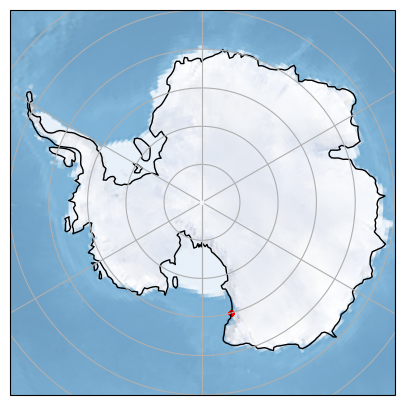

In [16]:
# Plot on Polar Map
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -65], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
ax.stock_img()
ax.gridlines()
gps_gdf.plot(ax=ax, markersize=10, color='red', transform=ccrs.PlateCarree(), aspect=None)

### Calibrate backscatter data with glider mean environmental data

We'll use the environmental data (temperature, salinity and pressure) found in the external glider file and the calibration parameters stored in the AZFP files to calibrate the backscatter data and create a volume backscattering strength (`Sv`) dataset.

In [17]:
# Grab and average environmental parameters
env_params_means = {}
for env_var in ["temperature", "salinity", "pressure"]:
    env_params_means[env_var] = float(ds_glider[env_var].mean().values)
env_params_means

{'temperature': -1.0206379890441895,
 'salinity': 34.53364181518555,
 'pressure': 38.69340133666992}

In [18]:
# Compute Sv
ds_Sv = ep.calibrate.compute_Sv(ed, env_params=env_params_means)
ds_Sv

<xarray.Dataset> Size: 88MB
Dimensions:                (channel: 3, ping_time: 920, range_sample: 1999,
                            filenames: 1)
Coordinates:
  * channel                (channel) <U11 132B '59006-38-1' ... '59006-200-3'
  * ping_time              (ping_time) datetime64[ns] 7kB 2018-01-11T07:44:40...
  * range_sample           (range_sample) int32 8kB 0 1 2 3 ... 1996 1997 1998
  * filenames              (filenames) int32 4B 0
Data variables: (12/18)
    Sv                     (channel, ping_time, range_sample) float64 44MB -1...
    echo_range             (channel, ping_time, range_sample) float64 44MB 0....
    frequency_nominal      (channel) float64 24B 3.8e+04 1.25e+05 2e+05
    sound_speed            float64 8B 1.444e+03
    sound_absorption       (channel) float64 24B 0.009111 0.03012 0.04501
    temperature            float64 8B -1.021
    ...                     ...
    TVR                    (channel) float64 24B 156.2 168.5 165.9
    VTX0                   (channel) float64 24B 157.0 146.7 133.3
    equivalent_beam_angle  (channel) float64 24B 0.1306 0.01071 0.01071
    Sv_offset              (channel) float64 24B 0.7 0.3 0.3
    source_filenames       (filenames) <U37 148B 'example_data\\glider_AZFP\\...
    water_level            float64 8B nan
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.10.2.dev12+gcb25040.d20250808
    processing_time:              2025-10-01T09:52:22+00:00
    processing_function:          calibrate.compute_Sv

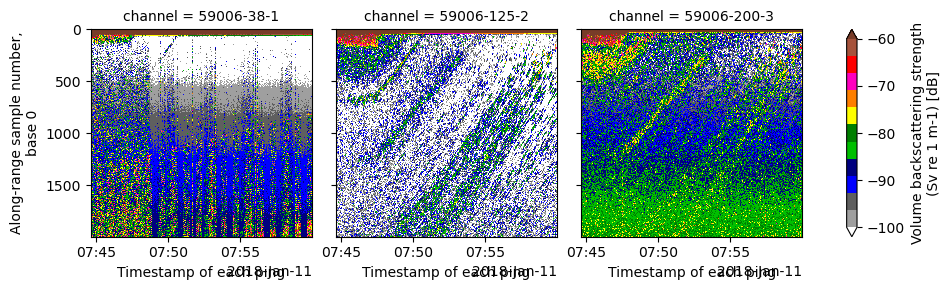

In [19]:
# Plot Sv
ds_Sv["Sv"].plot(
    col="channel", yincrease=False, y="range_sample",
    vmin=-100, vmax=-60, cmap="ep.ek500"
)

Note that the top portion of the echograms have extremely high Sv values. Let's drop these since they are most likely from noise or bubbles near the sea surface.

In [20]:
# Select Sv
ds_Sv = ds_Sv.isel(range_sample=slice(150,None))

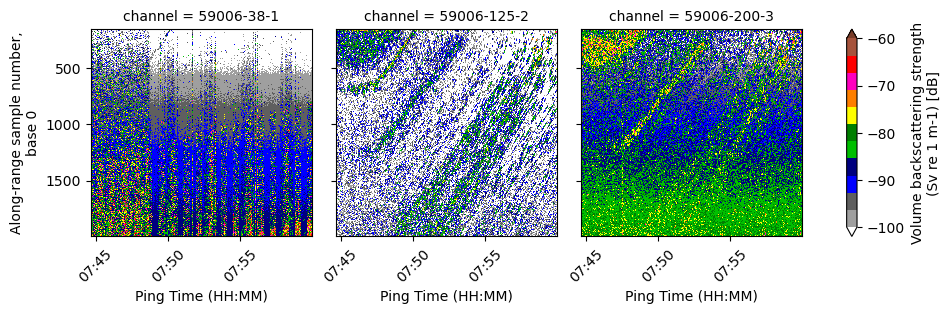

In [21]:
# Plot selected Sv:
g = ds_Sv["Sv"].plot(
    col="channel", yincrease=False, y="range_sample",
    vmin=-100, vmax=-60, cmap="ep.ek500"
)

# Iterate through each facet
for ax in g.axes.flatten():
    labels = [label.get_text() for label in ax.get_xticklabels()]
    # Set the current ticks
    ax.set_xticks(ax.get_xticks())
    # Apply rotation
    ax.set_xticklabels(labels, rotation=45)
    # Set x label
    ax.set_xlabel("Ping Time (HH:MM)")

plt.show()

### Remove background noise

Following [De Robertis and Higginbottom (2007)]((https://doi.org/10.1093/icesjms/fsm112)), we can remove background noise by estimating it from the mean calibrated power of a collection of pings.

In [22]:
# Remove background noise
ds_Sv = ep.clean.remove_background_noise(
    ds_Sv,
    ping_num=5,
    range_sample_num=5,
    # Threshold value from https://github.com/a-sheehan/Echopype-Processing-Pipeline-for-AZFP-and-Glider-Data/blob/main/Sheehan_azfp_forloop.ipynb
    SNR_threshold="2.0dB",
)

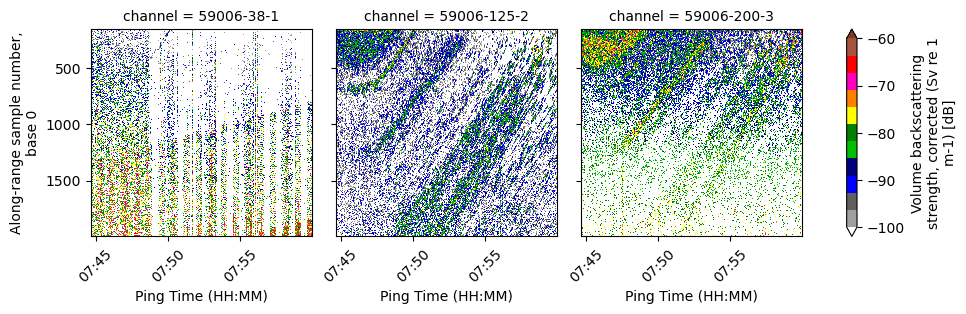

In [23]:
# Plot corrected Sv
g = ds_Sv["Sv_corrected"].plot(
    col="channel", yincrease=False, y="range_sample", vmin=-100, vmax=-60, cmap="ep.ek500"
)

# Iterate through each facet
for ax in g.axes.flatten():
    labels = [label.get_text() for label in ax.get_xticklabels()]
    # Set the current ticks
    ax.set_xticks(ax.get_xticks())
    # Apply rotation
    ax.set_xticklabels(labels, rotation=45)
    # Set x label
    ax.set_xlabel("Ping Time (HH:MM)")

plt.show()

Since we're most interested in 125 kHz for capturing zooplankton schools, let's look at the Sv histograms (with and without background noise removed) for the 125 kHz channels:

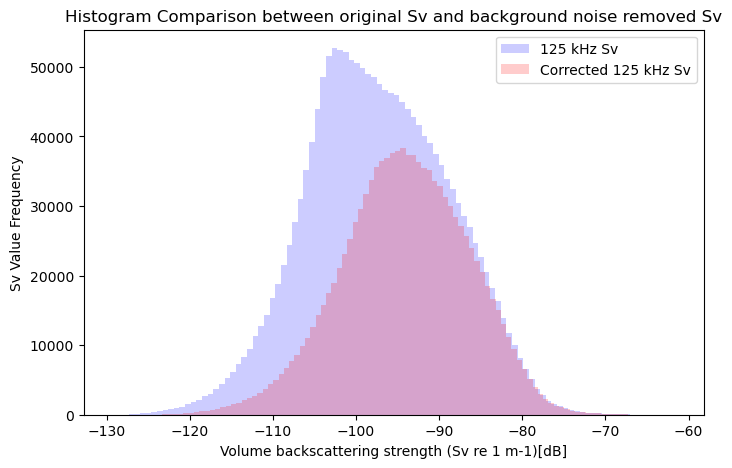

In [24]:
# Extract and flatten data from 125 kHz channels
data_Sv = ds_Sv["Sv"].sel(channel="59006-125-2").values.ravel() # Flatten
data_Sv_corrected = ds_Sv["Sv_corrected"].sel(channel="59006-125-2").values.ravel() # Flatten

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histograms
ax.hist(data_Sv, bins=100, color='blue', alpha=0.2, label='125 kHz Sv')
ax.hist(data_Sv_corrected, bins=100, color='red', alpha=0.2, label='Corrected 125 kHz Sv')

# Add labels, title, and legend
ax.set_xlabel("Volume backscattering strength (Sv re 1 m-1)[dB]")
ax.set_ylabel("Sv Value Frequency")
ax.set_title("Histogram Comparison between original Sv and background noise removed Sv")
ax.legend()

plt.show()

From both the histogram and the echogram images above, we can see that a significant amount of Sv values, between -120 and -90 dB, surrounding the orange and yellow regions in the 125 kHz channel have been removed. Being that the majority of values removed were so weak, we suspect that it was **mostly** background noise that was removed.

### Align echosounder data according to depth

#### What are `range_sample` and `echo_range`?

Since the glider is going downwards, displaying the echogram as we did in the Sv plots above is not correct since it does not display the backscatter at its respective depth. For Sv, we have `range_sample` which is the number of samples a particular echo samples measured starting from the moment the ping was transmitted.

In [25]:
# Show `range_sample`
ds_Sv["range_sample"]

<xarray.DataArray 'range_sample' (range_sample: 1849)> Size: 7kB
array([ 150,  151,  152, ..., 1996, 1997, 1998])
Coordinates:
  * range_sample  (range_sample) int32 7kB 150 151 152 153 ... 1996 1997 1998
Attributes:
    long_name:  Along-range sample number, base 0

To get the actual range (distance) of how far this echo pixel is from the transducer surface, the Sv dataset object also contains the `echo_range` variable that is calculated based on the sound speed (calculated from the environmental data) and sampling interval:

In [26]:
# Show `echo_range`
ds_Sv["echo_range"]

<xarray.DataArray 'echo_range' (channel: 3, ping_time: 920, range_sample: 1849)> Size: 41MB
array([[[ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        ...,
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902]],

       [[ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
...
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902]],

       [[ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        ...,
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902],
        [ 5.77733777,  5.81344613,  5.84955449, ..., 72.43337229,
         72.46948066, 72.50558902]]])
Coordinates:
  * channel       (channel) <U11 132B '59006-38-1' '59006-125-2' '59006-200-3'
  * ping_time     (ping_time) datetime64[ns] 7kB 2018-01-11T07:44:40 ... 2018...
  * range_sample  (range_sample) int32 7kB 150 151 152 153 ... 1996 1997 1998
Attributes:
    long_name:  Range distance
    units:      m

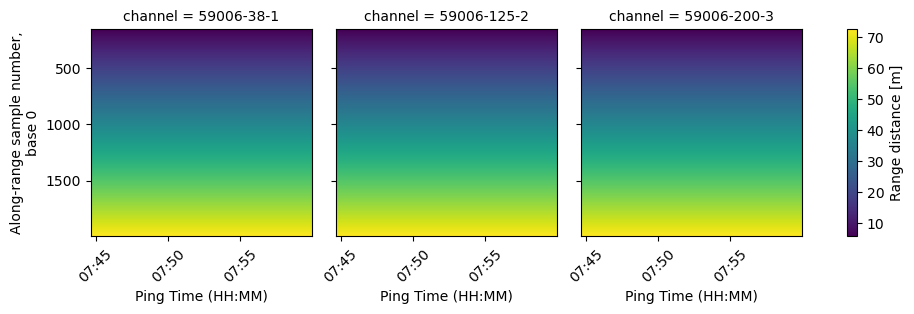

In [27]:
# Plot `echo_range`
g = ds_Sv["echo_range"].plot(col="channel", y="range_sample", yincrease=False)

# Iterate through each facet
for ax in g.axes.flatten():
    labels = [label.get_text() for label in ax.get_xticklabels()]
    # Set the current ticks
    ax.set_xticks(ax.get_xticks())
    # Apply rotation
    ax.set_xticklabels(labels, rotation=45)
    # Set x label
    ax.set_xlabel("Ping Time (HH:MM)")

plt.show()

In [28]:
# Show `echo_range` dimensions
ds_Sv["echo_range"].dims

('channel', 'ping_time', 'range_sample')

This is a 3D array, with the same dimensions as the Sv array. In this case, the `echo_range` is equal across channels and pings; however, this is not always the case and so we have to construct the `echo_range` variable as a 3D array.

Since `echo_range` is calculated from the surface of the transducer, we can use the `echo_range` variable and external parameters to compute a depth array that captures this downward movement of the glider and position the echogram at the right depth.

#### Adding depth to Sv

We can use external parameters from the `ds_glider` to compute depth. 

We must first convert the glider dataset's pitch and roll, which are in radians, into tilt, which is in degrees.

In [29]:
# Correct pitch based on the processing from:
# https://github.com/a-sheehan/Echopype-Processing-Pipeline-for-AZFP-and-Glider-Data/blob/main/Sheehan_azfp_forloop.ipynb
correct_pitch = ds_glider["m_pitch"].where(
    (ds_glider["m_pitch"]*180/np.pi < -15) & (ds_glider["m_pitch"]*180/np.pi > -30),
    other=np.nan
)

# Convert pitch and roll from radians to degrees
pitch = np.rad2deg(correct_pitch)
roll = np.rad2deg(ds_glider["m_roll"])

# Compute tilt in degrees from pitch roll rotations
yaw = np.zeros_like(pitch.values)
yaw_pitch_roll_euler_angles_stack = np.column_stack([yaw, pitch.values, roll.values])
yaw_rot_pitch_roll = R.from_euler("ZYX", yaw_pitch_roll_euler_angles_stack, degrees=True)
glider_tilt = yaw_rot_pitch_roll.as_matrix()[:, -1, -1]
glider_tilt = xr.DataArray(
    glider_tilt, dims="time", coords={"time": ds_glider["time"]}
)
glider_tilt_in_degrees = np.rad2deg(np.arccos(glider_tilt))
glider_tilt_in_degrees.attrs = {
    "long_name": "Tilt",
    "units": "Degrees"
}

Plotting glider tilt:

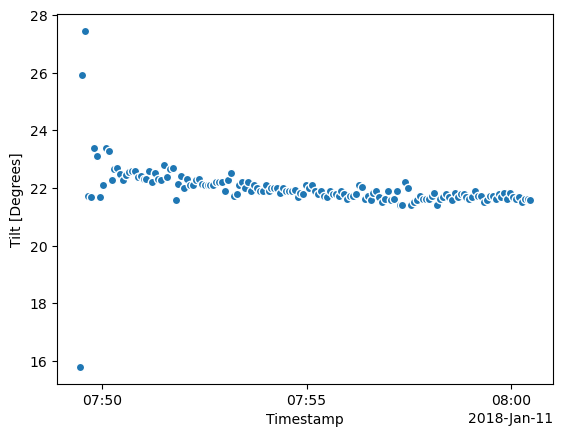

In [30]:
# Plot glider tilt
glider_tilt_in_degrees.plot.scatter()

Plotting glider specified depth:

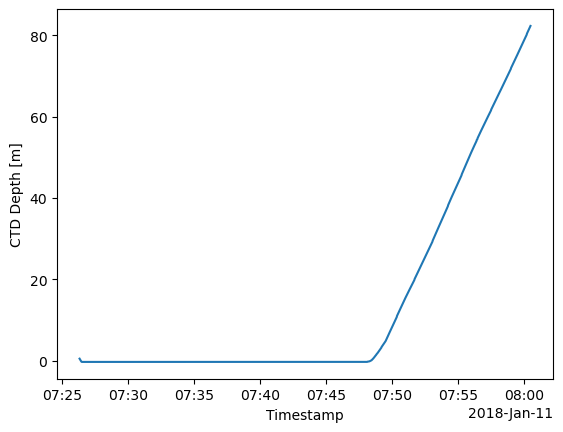

In [31]:
# Plot glider depth
ds_glider["depth"].dropna(dim="time").plot.line()

We use both angular and vertical offset information alongside `echo_range` in `ep.consolidate.add_depth` to correctly compute the depth that each backscatter data point corresponds to:

In [32]:
# Add depth to Sv dataset incorporating Glider depth and tilt data
ds_Sv = ep.consolidate.add_depth(
    ds_Sv,
    depth_offset=ds_glider["depth"].dropna("time"),
    tilt=glider_tilt_in_degrees.dropna("time"),
)

Plot the depth array:

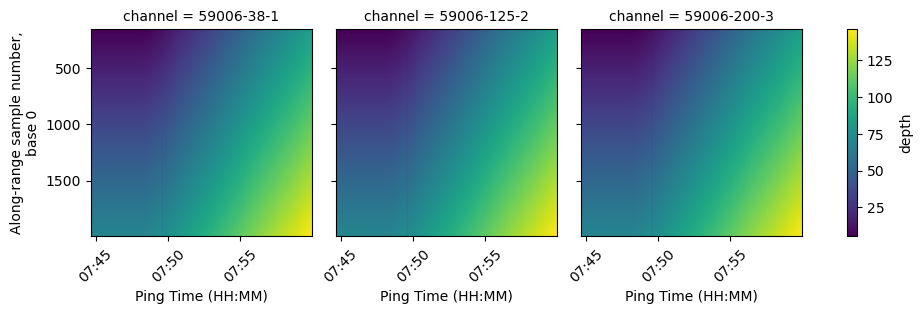

In [33]:
# Plot the depth array
g = ds_Sv["depth"].plot(col="channel", y="range_sample", yincrease=False)

# Iterate through each facet
for ax in g.axes.flatten():
    labels = [label.get_text() for label in ax.get_xticklabels()]
    # Set the current ticks
    ax.set_xticks(ax.get_xticks())
    # Apply rotation
    ax.set_xticklabels(labels, rotation=45)
    # Set x label
    ax.set_xlabel("Ping Time (HH:MM)")

plt.show()

Plot the 125 kHz channel of the Sv corrected dataset using depth as a 2D coordinate grid:

C:\Users\lloyd\AppData\Local\Temp\ipykernel_13948\3509394515.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh = plt.pcolormesh(


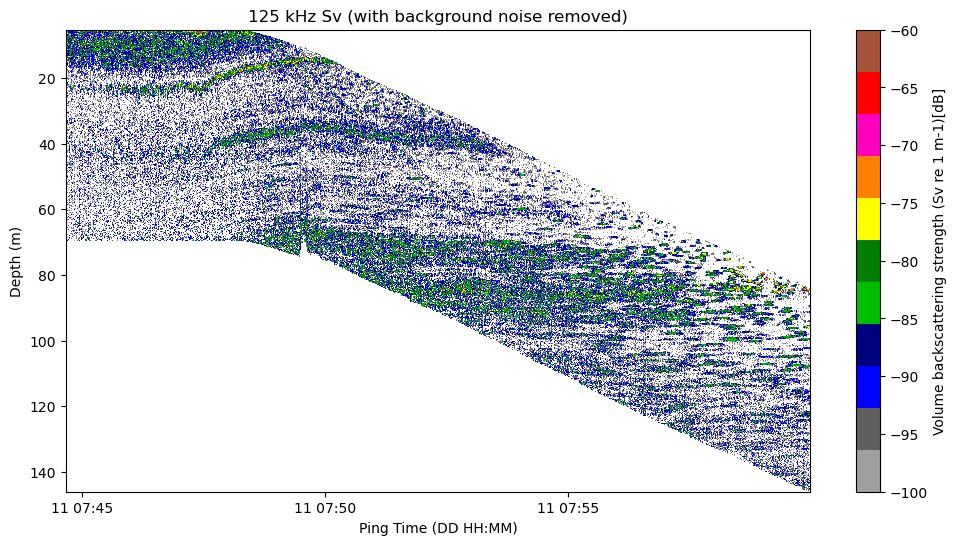

In [34]:
# Create a single subplot
fig, ax = plt.subplots(1,1,figsize=(12,6))

# Plot 125 kHz Sv corrected channel as a 2D mesh with depth and ping time coords
pcolormesh = plt.pcolormesh(
    ds_Sv["ping_time"].broadcast_like(ds_Sv["range_sample"]).values.T,
    ds_Sv["depth"].sel(channel="59006-125-2").values, 
    ds_Sv["Sv_corrected"].sel(channel="59006-125-2").values,
    shading='auto',
    vmin=-100,
    vmax=-60,
    cmap="ep.ek500",
)
plt.gca().invert_yaxis()

# Add title and axis labels
plt.title("125 kHz Sv (with background noise removed)")
plt.xlabel("Ping Time (DD HH:MM)")
plt.ylabel("Depth (m)")

# Add colorbar
plt.colorbar(pcolormesh, label="Volume backscattering strength (Sv re 1 m-1)[dB]")

# Show plot
plt.show()

Note that the first few roll and pitch angles may be inaccurate, and hence there is a small "jump" near the start of the dive in the depth of the echogram.

### Compute and apply shoal mask on corrected Sv

In the above, we have got our calibrated backscatter volume data into an easily manipulable array format. Here, we apply a shoal mask using echopype’s shoal-detection utilities. These functions are adapted from the open-source fisheries acoustics package, [Echopy](https://github.com/open-ocean-sounding/echopy).

We can use the implementation of Echoview's shoal detection algorithm to extract the zooplankton schools that we see in the echogram above.

In [35]:
from echopype.mask import detect_shoal

shoal_mask = detect_shoal(
    ds_Sv,
    method="echoview",
    params={
        "var_name": "Sv_corrected",
        "channel": "59006-125-2",
        "idim": np.arange(len(ds_Sv["range_sample"])+1),
        "jdim": np.arange(len(ds_Sv["ping_time"])+1),
        "thr": -90,
        "mincan": (5, 5),
        "maxlink": (30, 2),
        "minsho": (30, 2),
    }
)

The mask is binary, where 1 is within a zooplankton school, and 0 otherwise:

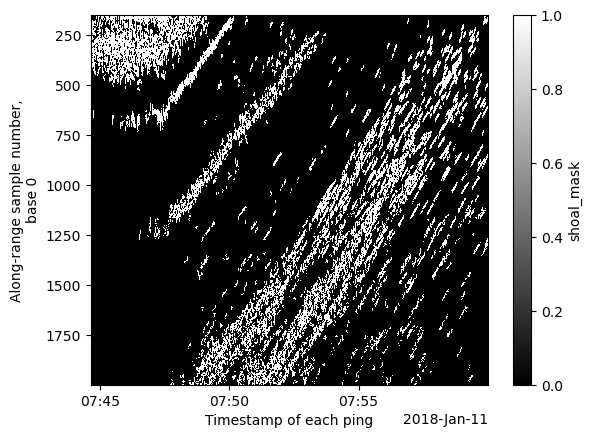

In [36]:
# Plot the school mask
shoal_mask.plot(yincrease=False, y="range_sample", cmap="gray")

In [37]:
# Apply shoal mask on the corrected Sv
ds_shoal_masked_Sv = ep.mask.apply_mask(ds_Sv, shoal_mask, var_name="Sv_corrected")

Plot the 125 kHz channel of the shoal masked Sv dataset using depth as a 2D coordinate grid:

C:\Users\lloyd\AppData\Local\Temp\ipykernel_13948\2654804491.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh = plt.pcolormesh(


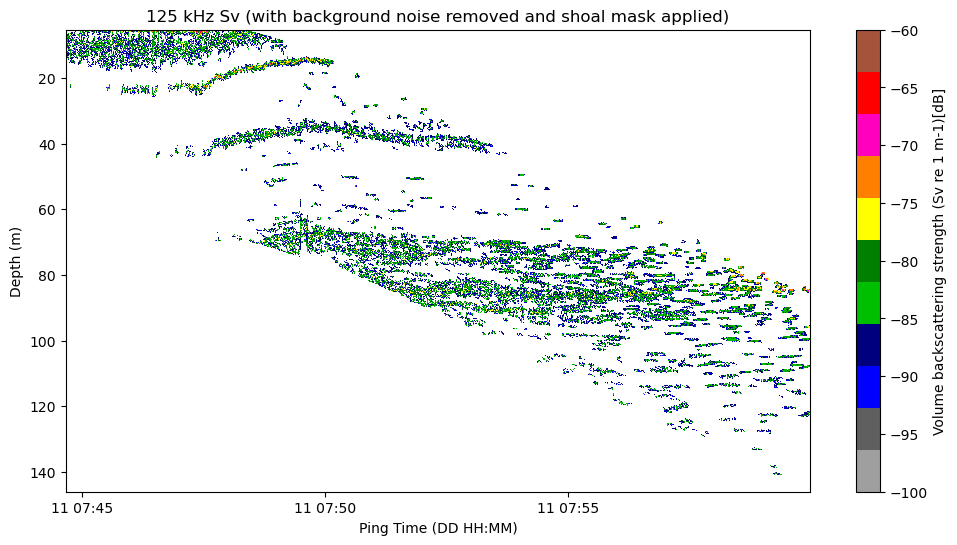

In [38]:
# Create a single subplot
fig, ax = plt.subplots(1,1,figsize=(12,6))

# Plot shoal masked 38 kHz Sv channel as a 2D mesh with depth and ping time coords
pcolormesh = plt.pcolormesh(
    ds_shoal_masked_Sv["ping_time"].broadcast_like(ds_shoal_masked_Sv["range_sample"]).values.T,
    ds_shoal_masked_Sv["depth"].sel(channel="59006-125-2").values, 
    ds_shoal_masked_Sv["Sv_corrected"].sel(channel="59006-125-2").values,
    shading='auto',
    vmin=-100,
    vmax=-60,
    cmap="ep.ek500",
)
plt.gca().invert_yaxis()

# Add title and axis labels
plt.title("125 kHz Sv (with background noise removed and shoal mask applied)")
plt.xlabel("Ping Time (DD HH:MM)")
plt.ylabel("Depth (m)")

# Add colorbar
plt.colorbar(pcolormesh, label="Volume backscattering strength (Sv re 1 m-1)[dB]")

# Show plot
plt.show()

## Package versions

In [39]:
import datetime
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}, geopandas: {gpd.__version__}")

print(f"\n{datetime.datetime.utcnow()} +00:00")

echopype: 0.10.2.dev12+gcb25040.d20250808, xarray: 2025.6.1, geopandas: 1.1.1

2025-10-01 09:55:06.767921 +00:00
